In [1]:
from pandas import concat , read_excel , DataFrame
from numpy import array
from glob import glob

### Data

In [2]:
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
df_atp = concat([read_excel(f) for f in ATP_FILES], ignore_index=True)

/Users/matis/miniforge3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


#### Data Processing

In [3]:
def toPlayerDict (df : DataFrame) -> dict :
    """
    Vectorisation of players
    return: dict of players 
        ex: {"Mister X." : 0, ...}
    """
    players : dict = dict()

    for match in range(len(df)):
        winner : str = df.loc[match, "Winner"]
        loser : str = df.loc[match, "Loser"]
        if winner not in players:
            players[winner] = len(players)
        if loser not in players:
            players[loser] = len(players)

    return players

In [4]:
def statMatchPlayer (df : DataFrame, previousDict : array(dict, dict) = None) :
    """
        Compute win's game or game have been played by player
        return : array of  two dicts  : [0] = playedMatch , [1] = winMatch
    """
    if  previousDict != None:                       #Continue the progression
        playedMatch = previousDict[0]
        winMatch = previousDict[1]
    else :                                          #Start at the beginning
        playedMatch = dict()
        winMatch = dict()

    match = sum(winMatch.values())

    winner : str = df.loc[match, "Winner"]
    loser : str  = df.loc[match, "Loser"]

    if winner in playedMatch :
        playedMatch[winner] += 1
        winMatch[winner] += 1
    else :
        playedMatch[winner] = 1
        winMatch[winner] = 1
        
    if loser in playedMatch :
        playedMatch[loser] += 1
    else : 
        playedMatch[loser] = 1
        winMatch[loser] = 0

    return (playedMatch , winMatch)

#statMatchPlayer(df_atp) # step 1
#statMatchPlayer(df_atp, statMatchPlayer(df_atp)) #step 2

In [5]:
def DataFrameStatusMaker (df : DataFrame):
    """
    Compute few things like ratio or game have been played by player
    return : DataFrame
    """
    data : list = []
    dictStatus : tuple(dict,dict) = statMatchPlayer(df)
    for match in range (len(df)):
        if match != 0:
            dictStatus = statMatchPlayer(df, dictStatus)

        J1 : str = df.loc[match, "Winner"]
        J2 : str  = df.loc[match, "Loser"]

        ratioJ1: float = 0
        ratioJ2: float = 0

        #Case of : divided by zero
        if dictStatus[0][J1] - 1 > 0 :
            ratioJ1: float = (dictStatus[1][J1] - 1 )/(dictStatus[0][J1] - 1)
        if dictStatus[0][J2] - 1 > 0 :
            ratioJ2: float = (dictStatus[1][J2] - 1 )/(dictStatus[0][J2] - 1)


        data.append([   ratioJ1,                # Ratio J1
                        ratioJ2,                # Ratio J2
                        (dictStatus[0][J1] - 1 ), # Nb Macth J1
                        (dictStatus[0][J2] - 1 )  # Nb Match J2
                    ])


    return DataFrame(    array(data), 
                            columns=["Ratio_J1" ,"Ratio_J2","NbMatch_J1", "NbMatch_J2"
                        ])

In [6]:
def renameClassInOneHot (df : DataFrame, dictPlayer : dict , inplace = False ) -> DataFrame :
    """
    Rename Player name by number class 
    return : DataFrame
    """
    if inplace:
        tempDf : DataFrame = df
    else: 
        tempDf : DataFrame = df.copy()

    for match in range (len(tempDf)):
        J1 : str = tempDf.loc[match, "J1"]
        J2 : str = tempDf.loc[match, "J2"]
        tempDf.loc[match, "J1"] = dictPlayer[J1]
        tempDf.loc[match, "J2"] = dictPlayer[J2]
        tempDf.loc[match, "Winner"] = dictPlayer[J1]

    return tempDf    

In [7]:
def reRanking (df : DataFrame) -> None:  
    """
    Reranking players haven't rank to 10000
    """
    for match in range (len(df)):
        if str(df.loc[match, "J1_Rank"]) == "NR" or str(df.loc[match, "J1_Rank"]) == "nan":
            df.loc[match, "J1_Rank"] = 10000

        if str(df.loc[match, "J2_Rank"]) == "NR" or str(df.loc[match, "J2_Rank"]) == "nan":
            df.loc[match, "J2_Rank"] = 10000

**Structure de DataFrame**

date | J1 | J2 | Rank J1 | Rank J2 | WinRatio J1 | WinRatio J2 | NbMatch J1 | NbMatch J2 | Winner

In [8]:
def DataFrameMaker(df: DataFrame) -> DataFrame:
    """
    Make the final DataFrame for explotation
    return : DataFrame
    """
    dictPlayer : dict = toPlayerDict(df)

    DataFrame : DataFrame =  concat([df["Date"], df["Winner"], df["Loser"], df["WRank"], df["LRank"], DataFrameStatusMaker(df), df["Winner"]], axis=1)
    DataFrame.columns = ["Date", "J1", "J2", "J1_Rank", "J2_Rank", "Ratio_J1", "Ratio_J2", "NbMatch_J1" , "NbMatch_J2" , "Winner"]
    DataFrame = renameClassInOneHot(DataFrame, dictPlayer)

    reRanking(DataFrame)    #Reatribute value of non-ranked person -> 10000

    ## TO DO : Random Switch between J1 & J2 to dodge overfitting on position dataset 

    #DataFrame.set_index('Date', inplace=True)
    return DataFrame

In [9]:
t = DataFrameMaker(df_atp)
t

,Date,J1,J2,J1_Rank,J2_Rank,Ratio_J1,Ratio_J2,NbMatch_J1,NbMatch_J2,Winner
0,2000-01-03,0,1,63,77,0.000000,0.000000,0.0,0.0,0
1,2000-01-03,2,3,5,56,0.000000,0.000000,0.0,0.0,2
2,2000-01-03,4,5,40,655,0.000000,0.000000,0.0,0.0,4
3,2000-01-03,6,7,65,87,0.000000,0.000000,0.0,0.0,6
4,2000-01-03,8,9,81,198,0.000000,0.000000,0.0,0.0,8
...,...,...,...,...,...,...,...,...,...,...
52293,2018-11-16,1216,831,5,10.0,0.664032,0.621035,253.0,599.0,1216
52294,2018-11-16,645,701,1,7.0,0.829876,0.650585,964.0,684.0,645
52295,2018-11-17,1216,6,5,3.0,0.665354,0.828402,254.0,1352.0,1216
52296,2018-11-17,645,838,1,6.0,0.830052,0.587902,965.0,529.0,645


#### Modification D'instance du Dataset

In [10]:
temp = t.copy()
del temp["Date"]
temp = temp.astype(float)
y  = temp["Winner"]
del temp["Winner"]
X = temp

In [11]:
X

,J1,J2,J1_Rank,J2_Rank,Ratio_J1,Ratio_J2,NbMatch_J1,NbMatch_J2
0,0.0,1.0,63.0,77.0,0.000000,0.000000,0.0,0.0
1,2.0,3.0,5.0,56.0,0.000000,0.000000,0.0,0.0
2,4.0,5.0,40.0,655.0,0.000000,0.000000,0.0,0.0
3,6.0,7.0,65.0,87.0,0.000000,0.000000,0.0,0.0
4,8.0,9.0,81.0,198.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...
52293,1216.0,831.0,5.0,10.0,0.664032,0.621035,253.0,599.0
52294,645.0,701.0,1.0,7.0,0.829876,0.650585,964.0,684.0
52295,1216.0,6.0,5.0,3.0,0.665354,0.828402,254.0,1352.0
52296,645.0,838.0,1.0,6.0,0.830052,0.587902,965.0,529.0


### Modèle  -  Random Forest

In [12]:
# ML Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , recall_score, confusion_matrix , f1_score
from sklearn.model_selection import train_test_split

# Visual
from matplotlib import pyplot as plt

# Compute
import numpy as np

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
clf = RandomForestClassifier(max_depth=20, random_state=1, criterion="entropy", max_features="log2")
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, max_features='log2',
                       random_state=1)

#### Mesures

In [15]:
preds = clf.predict(X_test)

##### Justesse (Accuracy)

In [16]:
accuracy_score(y_test, preds)

0.9410742221449678

##### Rappel (Recall)

In [17]:
recall_score(y_test, preds, average="weighted", zero_division = 1)

0.9410742221449678

##### F Score

In [18]:
f1 = f1_score(y_test, preds, average="weighted")
f1

0.9382062399943855

##### Matrice de confusion

In [19]:
z = confusion_matrix(y_test, preds)
z

array([[  3,   2,   0, ...,   0,   0,   0],
       [  1, 126,   0, ...,   0,   0,   0],
       [  0,   0,  39, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

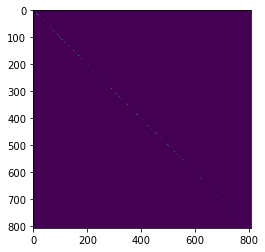

In [20]:
plt.imshow(z, interpolation='nearest')
plt.show()